In [54]:
import numpy as np
import cv2

def apply_fourier_transform(image):
    """Compute the DFT and shift the zero-frequency component to the center"""
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    return dft_shifted


def inverse_fourier_transform(dft_shifted):
    """Reverse the Fourier transform and return the magnitude"""
    dft_shifted = np.fft.ifftshift(dft_shifted)  # Shift back
    img_back = cv2.idft(dft_shifted)
    img_back = cv2.magnitude(
        img_back[:, :, 0], img_back[:, :, 1])  # Compute magnitude
    # Normalize for display
    return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)


def create_filter(shape, filter_type, d0=30, order=2):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            d = np.sqrt((u - crow) ** 2 + (v - ccol)
                        ** 2)  # Distance from center

            if filter_type == 'ideal_lowpass':
                mask[u, v] = 1 if d <= d0 else 0
            elif filter_type == 'butterworth_lowpass':
                mask[u, v] = 1 / (1 + (d / d0) ** (2 * order))
            elif filter_type == 'gaussian_lowpass':
                mask[u, v] = np.exp(-(d ** 2) / (2 * d0 ** 2))
            elif filter_type == 'ideal_highpass':
                mask[u, v] = 0 if d <= d0 else 1
            elif filter_type == 'butterworth_highpass':
                mask[u, v] = 1 - (1 / (1 + (d / d0) ** (2 * order)))
            elif filter_type == 'gaussian_highpass':
                mask[u, v] = 1 - np.exp(-(d ** 2) / (2 * d0 ** 2))

    return mask

# Image Enhancement

## [1] Component Extraction

### Circle

In [4]:
import cv2
import numpy as np
from skimage import restoration
import matplotlib.pyplot as plt

image_path = 'media/7 circles.png'  # Path to the input image
output_path = 'output_image_circle.jpg'  # Path to save the output image

# 1. Circle - Hough Circle Transform
img_circle = cv2.imread(image_path, 0)
blurred_circle = cv2.GaussianBlur(img_circle, (5, 5), 0)
circles = cv2.HoughCircles(blurred_circle, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                           param1=50, param2=30, minRadius=0, maxRadius=0)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img_circle, (x, y), r, (255), 4)
cv2.imwrite(output_path, img_circle)

True

### Covid Chart

In [3]:
image_path_chart = 'media/Multi_objects_separation.jpeg'
img_chart = cv2.imread(image_path_chart, 0)

# Gaussian blur to reduce noise
blurred_chart = cv2.GaussianBlur(img_chart, (5, 5), 0)


# Alternative: Adaptive thresholding (uncomment to try if Otsu's fails)
thresh = cv2.adaptiveThreshold(blurred_chart, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Save the thresholded image for debugging
cv2.imwrite('thresh_chart.jpg', thresh)

# Apply erosion instead of dilation to separate slightly connected objects
kernel = np.ones((3, 3), np.uint8)
eroded = cv2.erode(thresh, kernel, iterations=1)

# Save the eroded image for debugging
cv2.imwrite('eroded_chart.jpg', eroded)

# Find contours on the eroded image
contours, _ = cv2.findContours(
    eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding rectangles, filtering small contours
min_area = 100  # Adjust this value based on your image
for c in contours:
    if cv2.contourArea(c) > min_area:  # Ignore contours below minimum area
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(img_chart, (x, y), (x + w, y + h), (255), 2)

# Save the final output
cv2.imwrite('output_image_chart.jpg', img_chart)

print("Processing complete. Check 'thresh_chart.jpg', 'eroded_chart.jpg', and 'output_image_chart.jpg' to verify results.")

Processing complete. Check 'thresh_chart.jpg', 'eroded_chart.jpg', and 'output_image_chart.jpg' to verify results.


## [2] Enhance of blurry images

### Buildings.jpg

#### Histogram equalization and CLAHE

(-0.5, 625.5, 416.5, -0.5)

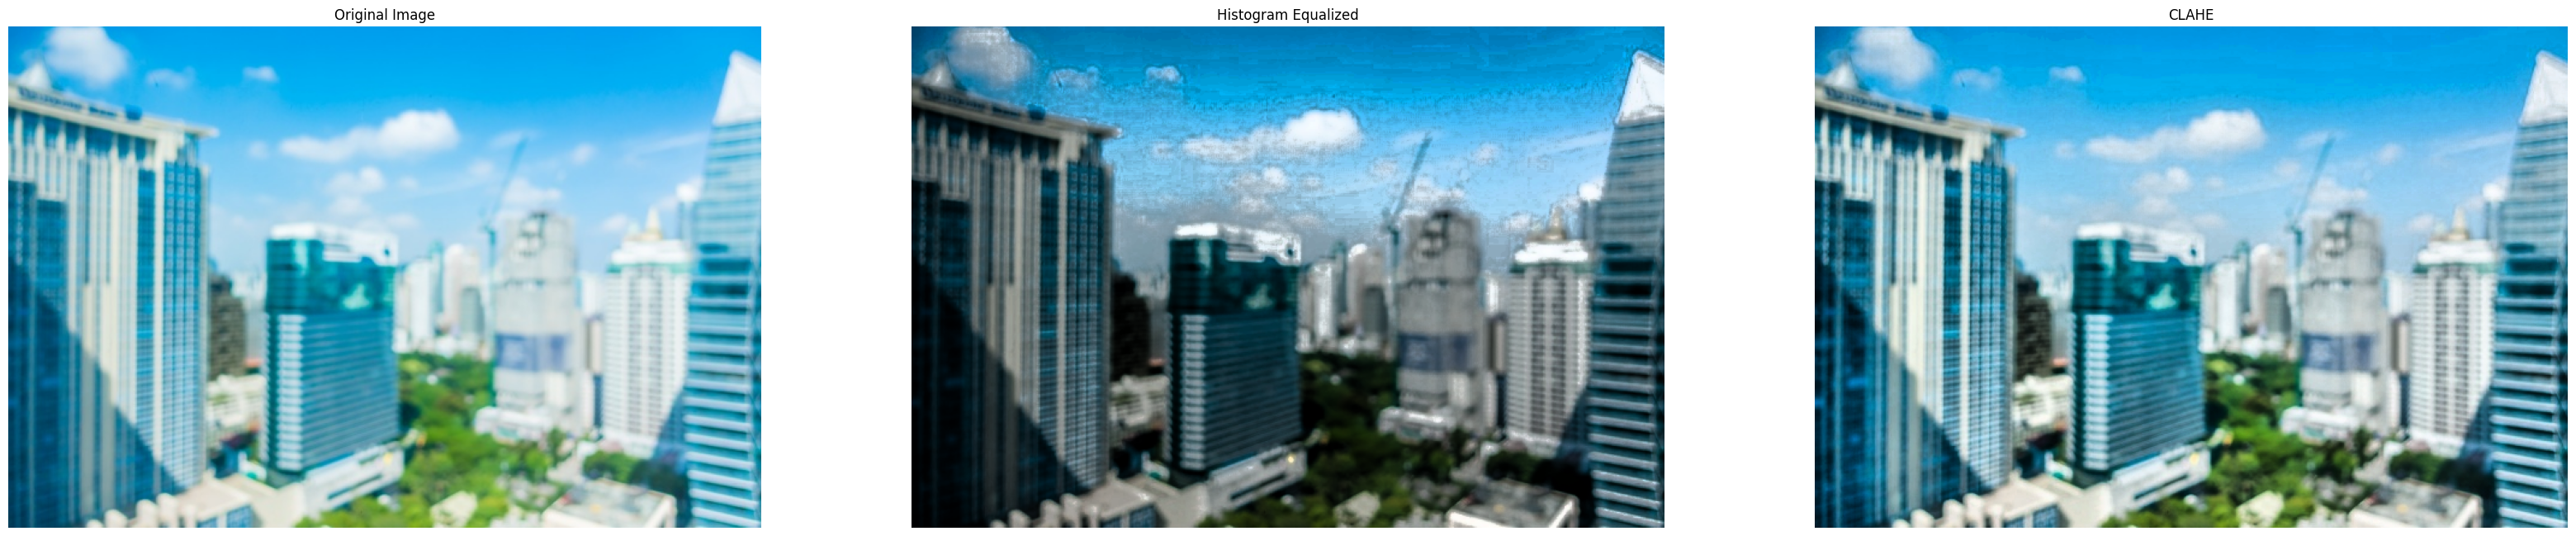

In [49]:
image_path_building = 'media/building.jpg'

# Read the image
img_building = cv2.imread(image_path_building)  # Read the image in color (default mode)

# Convert to HSV
imhsv = cv2.cvtColor(img_building, cv2.COLOR_BGR2HSV)
imhsvCLAHE = imhsv.copy()

# Perform histogram equalization only on the V channel
imhsv[:, :, 2] = cv2.equalizeHist(imhsv[:, :, 2])

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
imhsvCLAHE[:, :, 2] = clahe.apply(imhsvCLAHE[:, :, 2])

# Convert back to BGR format
imEq = cv2.cvtColor(imhsv, cv2.COLOR_HSV2BGR)
imEqCLAHE = cv2.cvtColor(imhsvCLAHE, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(40, 40))

ax = plt.subplot(1, 3, 1)
plt.imshow(img_building[:, :, ::-1], vmin=0, vmax=255)
ax.set_title("Original Image")
ax.axis('off')


ax = plt.subplot(1, 3, 2)
plt.imshow(imEq[:, :, ::-1], vmin=0, vmax=255)
ax.set_title("Histogram Equalized")
ax.axis('off')

ax = plt.subplot(1, 3, 3)
plt.imshow(imEqCLAHE[:, :, ::-1], vmin=0, vmax=255)
ax.set_title("CLAHE")
ax.axis('off')

In [76]:
# Adjusting brightness and contrast
def adjust_brightness_contrast(image, alpha=1.0, beta=0):
    """Adjust brightness and contrast of the image"""
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
# Sharpening images
def sharpen_image(image, alpha=1.5, beta=0):
    """Sharpen the image using a kernel"""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return adjust_brightness_contrast(sharpened, alpha, beta)

# Removing noise from images
def remove_noise(image):
    """Remove noise using Non-Local Means Denoising"""
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# Enhancing color in images
def enhance_color(image, alpha=1.5, beta=0):
    """Enhance color using CLAHE"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_Lab2BGR)

# Image resizing and scaling
def resize_image(image, scale_percent):
    """Resize the image by a percentage"""
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# Inverse Transform
def inverse_transform(image):
    """Apply inverse Fourier transform to the image"""
    dft_shifted = apply_fourier_transform(image)
    img_back = inverse_fourier_transform(dft_shifted)
    return img_back

# Equalizing histograms
def equalize_histogram(image):
    """Equalize the histogram of the image"""
    return cv2.equalizeHist(image)
  

# apply the functions to the image
img_building = cv2.imread(image_path_building, 0)  # Read the image in grayscale
img_building = cv2.resize(img_building, (0, 0), fx=0.5, fy=0.5)  # Resize the image

img_building = adjust_brightness_contrast(img_building, alpha=1.2, beta=30)  # Adjust brightness and contrast
img_building = sharpen_image(img_building, alpha=0.5, beta=50)  # Sharpen the image
# # Convert grayscale image to color before removing noise
# img_building_color = cv2.cvtColor(img_building, cv2.COLOR_GRAY2BGR)
# img_building_color = remove_noise(img_building_color)  # Remove noise
# img_building = cv2.cvtColor(img_building_color, cv2.COLOR_BGR2GRAY)  # Convert back to grayscale
# # Convert grayscale image to BGR before enhancing color
# img_building_bgr = cv2.cvtColor(img_building, cv2.COLOR_GRAY2BGR)
# img_building = enhance_color(img_building_bgr, alpha=1.5, beta=0)  # Enhance color

# img_building = resize_image(img_building, scale_percent=100)  # Resize the image
# # Ensure the image is grayscale before applying histogram equalization
# if len(img_building.shape) == 3:  # Check if the image has multiple channels
#     img_building = cv2.cvtColor(img_building, cv2.COLOR_BGR2GRAY)
# img_building = equalize_histogram(img_building)  # Equalize histogram

# img_building = inverse_transform(img_building)  # Apply inverse Fourier transform
img_building = cv2.normalize(img_building, None, 0, 255, cv2.NORM_MINMAX)  # Normalize the image

img_building = np.uint8(img_building)  # Convert to uint8
cv2.imwrite('output_image_building.jpg', img_building)  # Save the output image


True

In [5]:
import cv2
import numpy as np

# Load the image
img_building = cv2.imread('media/building.jpg')
# Convert to HSV and apply CLAHE to the V channel
imhsv = cv2.cvtColor(img_building, cv2.COLOR_BGR2HSV)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
imhsv[:, :, 2] = clahe.apply(imhsv[:, :, 2])
img_building = cv2.cvtColor(imhsv, cv2.COLOR_HSV2BGR)
# Apply sharpening
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
img_building = cv2.filter2D(img_building, -1, kernel)
# Save the output
cv2.imwrite('output_image_building.jpg', img_building)

True

### Dog

In [6]:
import cv2

# Load the image
img_dog = cv2.imread('media/Dog.jpeg')
# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_dog, (5, 5), 0)
# Apply unsharp masking
img_dog = cv2.addWeighted(img_dog, 1.5, blurred, -0.5, 0)
# Save the output
cv2.imwrite('output_image_dog.jpg', img_dog)

True

## [3] Noise Removal

### Text

Applying Gaussian filter then sharpening the image using kernel convolution.

median filter was tested but it was not as effective as Gaussian filter.

sharpening was very good on the orginal image but not on the blurred image.

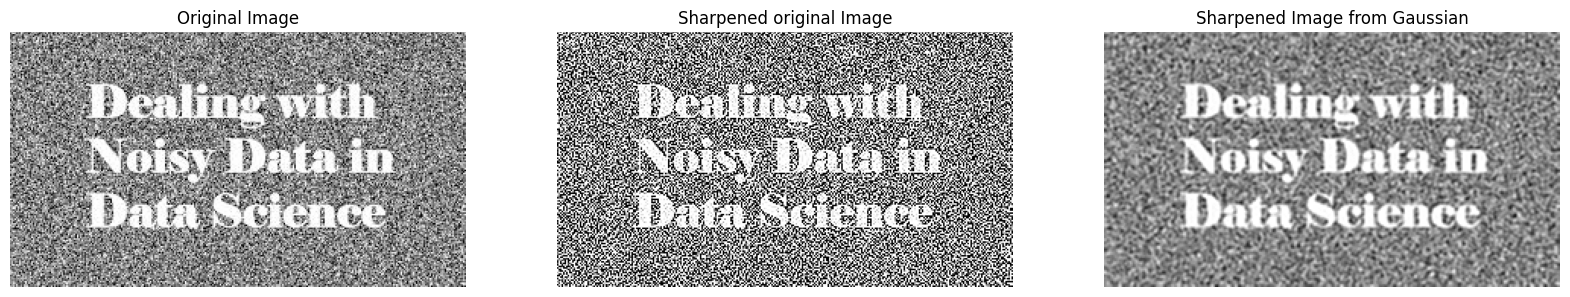

In [35]:
import cv2

# Load the image (assuming color for denoising compatibility)
img_text = cv2.imread('media/Text.jpeg', cv2.IMREAD_COLOR)

img_text_gaussian = cv2.GaussianBlur(img_text, (5, 5), 0,0)  # Apply Gaussian blur

# img_text_median = cv2.medianBlur(img_text, 5)  # Apply median blur

sharpen = np.array([[0, -1, 0],
               [-1, 5, -1],
               [0, -1, 0]])  # Define sharpening kernel

img_text_sharpened = cv2.filter2D(
    img_text, -1, sharpen)  # Apply sharpening

img_text_sharpened_from_gaussian = cv2.filter2D(img_text_gaussian, -1, sharpen)  # Apply sharpening

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img_text[:, :, ::-1], vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_text_sharpened[:, :, ::-1], vmin=0, vmax=255)
plt.title("Sharpened original Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_text_sharpened_from_gaussian[:, :, ::-1], vmin=0, vmax=255)
plt.title("Sharpened Image from Gaussian")
plt.axis('off')
plt.show()

# cv2.imwrite('output_image_text.jpg', img_text)  # Save the output image

### Rocket